In [ ]:
# This notebook performs a statistical analysis on the psychometric performance
# of mice under optoinhibition

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install mouse-behavior-analysis-tools
%cd APE_paper/docs/figures_notebooks

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from os.path import exists
import urllib.request

from mouse_behavior_analysis_tools.utils import custom_functions as cuf
from mouse_behavior_analysis_tools.utils.misc_utils import update_progress
from mouse_behavior_analysis_tools.plot import make_figures

In [2]:
# download data from server
dataset_name = 'Optoinhibition-after-learning_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
oal_df = pd.read_csv(dataset_path, index_col=0)

Data already in directory


### Generate a dataset of random optostimulation choices
#### This is creating picking random choices, and matching trial number per session and difficulty, from trials in which there was no stimulation.
#### Compare this to the real data and get differences

In [3]:
# Specify the number of random datasets to do
n_times = 1000

# Compute the random dataframe
random_opto_df = cuf.get_random_dataframe_for_optostimulation(oal_df, n_times)

Adding info - Progress: [####################] 100.0%
Done computing the random dataframe


In [7]:
def significance_calculator(panda_series):
    cbe = panda_series.bias
    # get contra value
    if panda_series.stimulated_side == "Left":
        cbe = [-x for x in cbe]

    if panda_series.Genotype == "D1opto":
        n_sig = np.sum([x > 0 for x in cbe])
    if panda_series.Genotype == "D2opto":
        n_sig = np.sum([x < 0 for x in cbe])

    return n_sig / len(cbe)

# Calculate the contralateral significance of each session
random_opto_df['significance_value'] = [significance_calculator(random_opto_df.loc[x]) for x in random_opto_df.index.values]

### Generate **Figure 1E**

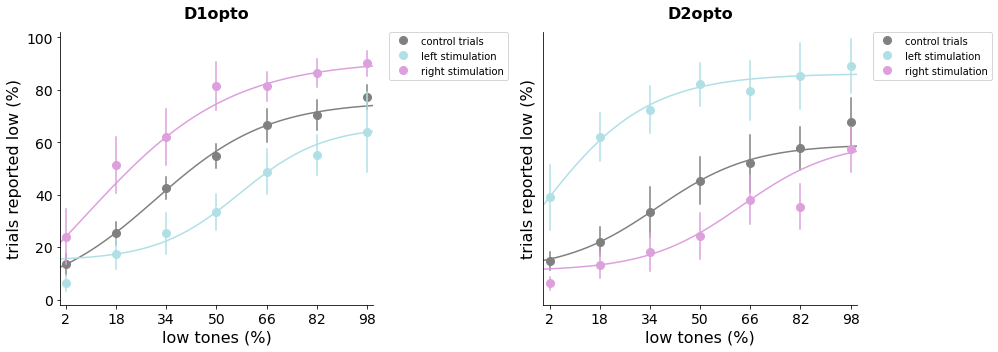

In [9]:
fig = make_figures.make_figure_optoinhibition_after_learning_curves(oal_df, random_opto_df)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_after_learning_curves.pdf',
#             transparent=True, bbox_inches='tight')

In [12]:
# save the data for the figure
import sys
sys.path.append('../../utils')
from excel_saver import save_figure_data_to_excel
save_figure_data_to_excel(fig, '../../graphs_excel_format/figure_1e_data.xlsx')

Data has been saved to ../../graphs_excel_format/figure_1e_data.xlsx


#### Generate **Figure 1F**

In [ ]:
fig = make_figures.make_figure_optoinhibition_after_learning_batch(random_opto_df)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_after_learning_batch.pdf',
#             transparent=True, bbox_inches='tight')

In [ ]:
# Calculate effect sizes
from scipy import stats
import random
def hack_for_effect_sizes(random_opto_df):
    exp_means = []
    cont_sds = []

    jitter = 0.3
    alpha = 1
    spread = jitter * 1.6
    mice_cohorts = ["D1opto", "D2opto"]
    colors = ["skyblue", "olivedrab"]
    labels_for_legend = ["D1-Arch", "D2-Arch"]

    fig, axs = plt.subplots(
        1, len(mice_cohorts), figsize=(4 * len(mice_cohorts), 8), sharey=True
    )

    axs = axs.ravel()
    for i, ax in enumerate(axs):
        ax.axhline(0, color="grey", linestyle="--")
        ax.set_title(labels_for_legend[i], fontsize=20)
        ax.set_xticks([])
        ax.set_xlim([-jitter * 1.2, jitter * 3])
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)

        # for tick in ax.yaxis.get_major_ticks():
        #     tick.label.set_fontsize(14)

        xmin, _ = axs[0].get_xaxis().get_view_interval()
        ax.plot((xmin, xmin), (-60, 40), color="black", linewidth=1)

    axs[0].set_ylabel("contralateral bias", fontsize=15)

    jit_list = []

    # plot stds
    for session in pd.unique(random_opto_df.SessionID):
        session_idx = random_opto_df.index[
            random_opto_df.SessionID == session
        ].item()
        cohort = random_opto_df.loc[session_idx].Genotype
        ax = axs[mice_cohorts.index(cohort)]
        st_t_idx = 0
        sh_d = random_opto_df.loc[session_idx].contralateral_bias
        sh_std = random_opto_df.loc[session_idx].bias_std
        imp_jit = random.uniform(-jitter, jitter)
        x_pos = st_t_idx + imp_jit
        jit_list.append(x_pos)

        # stds
        ax.plot(
            [x_pos, x_pos],
            [sh_d - sh_std, sh_d + sh_std],
            color=colors[mice_cohorts.index(cohort)],
            linewidth=3,
            alpha=alpha,
        )

    counter = 0
    # plot means on top
    mean_vals = [[], []]
    sessions_used = [[], []]
    for session in pd.unique(random_opto_df.SessionID):
        session_idx = random_opto_df.index[
            random_opto_df.SessionID == session
        ].item()
        cohort = random_opto_df.loc[session_idx].Genotype
        ax = axs[mice_cohorts.index(cohort)]
        st_t_idx = 0
        sh_d = random_opto_df.loc[session_idx].contralateral_bias
        imp_jit = random.uniform(-jitter, jitter)
        x_pos = jit_list[counter]
        counter += 1
        if random_opto_df.loc[session_idx].significance_value < .05:
          # means
          ax.plot(
              x_pos,
              sh_d,
              "o",
              ms=14,
              color="k",
              markerfacecolor=colors[mice_cohorts.index(cohort)],
          )
        else:
          ax.plot(
              x_pos,
              sh_d,
              "o",
              ms=14,
              color=colors[mice_cohorts.index(cohort)],
              markerfacecolor="white",
          )
        # append to list
        mean_vals[mice_cohorts.index(cohort)].append(sh_d)
        sessions_used[mice_cohorts.index(cohort)].append(session)

    # plot mean of means next to it, and random distribution, and pvalue
    pvals = []
    for i, ax in enumerate(axs):
        exp_means.append(np.mean(mean_vals[i]))

        # boxplot
        bp = ax.boxplot(
            mean_vals[i],
            positions=[spread],
            widths=0.07,
            patch_artist=True,
            showfliers=False,
        )
        for element in [
            "boxes",
            "whiskers",
            "fliers",
            "means",
            "medians",
            "caps",
        ]:
            plt.setp(bp[element], color=colors[i], linewidth=3)
        for patch in bp["boxes"]:
            patch.set(facecolor="white")

        # random expectation. Mean at 0 by definition.
        # Use the bias_std to sample from
        # do one instance only
        random_means = []
        for session in sessions_used[i]:
            # get x number of a random bias
            sess_std = random_opto_df[
                random_opto_df.SessionID == session
            ].bias_std.values
            random_means.append(
                np.random.normal(loc=0.0, scale=sess_std[0], size=100)
            )
        random_means_flat_list = [
            item for sublist in random_means for item in sublist
        ]
        cont_sds.append(np.std(random_means_flat_list))
        spr_adj = 1.5
        bp = ax.boxplot(
            random_means_flat_list,
            positions=[spread * spr_adj],
            widths=0.07,
            patch_artist=True,
            showfliers=False,
        )
        for element in [
            "boxes",
            "whiskers",
            "fliers",
            "means",
            "medians",
            "caps",
        ]:
            plt.setp(bp[element], color="lightgray", linewidth=3)
        for patch in bp["boxes"]:
            patch.set(facecolor="white")

        pvals.append(
            stats.kruskal(mean_vals[i], random_means_flat_list).pvalue
        )

        # print the cohen's d value for effect size
        c0 = mean_vals[i]
        c1 = random_means_flat_list
        cohens_d = (np.mean(c0) - np.mean(c1)) / (np.sqrt((np.std(c0) ** 2 + np.std(c1) ** 2) / 2))
        print(f"Cohen's d for {labels_for_legend[i]}: {cohens_d}")

    # add pvalues info
    hlocs = [20, -20]
    hadj = [1.2, 1.4]

    for i, ax in enumerate(axs):
        pvaltext = "{0:.7f}".format(pvals[i])
        ax.text(
            x=spread * (1 + spr_adj) / 2,
            y=hlocs[i] * hadj[i],
            s="pval {}".format(str(pvaltext)),
            horizontalalignment="center",
            fontsize=14,
        )
        ax.plot(
            [spread, spread * spr_adj],
            [hlocs[i], hlocs[i]],
            color="k",
            linewidth=0.5,
        )
        ax.plot(
            [spread, spread],
            [hlocs[i], hlocs[i] * 0.8],
            color="k",
            linewidth=0.5,
        )
        ax.plot(
            [spread * spr_adj, spread * spr_adj],
            [hlocs[i], hlocs[i] * 0.8],
            color="k",
            linewidth=0.5,
        )
        ax.set_xticks([])

    return exp_means, cont_sds, fig


m, std, fig = hack_for_effect_sizes(random_opto_df)

fig.show()

In [ ]:
fig.savefig('Fig1f_with_significance.pdf', dpi=300, bbox_inches='tight')

In [ ]:
[m[x] / std[x] for x in range(len(m))]



In [ ]:
m

In [ ]:
random_opto_df